## 5. CRISP-DM: Modeling

## Training and Evaluation

10446


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating initial models:


,Accuracy,ROC AUC
Majority Classifier,0.948628,0.500000
Logistic Regression,0.948628,0.782940
Decision Tree,0.926930,0.615458
Random Forest,0.945118,0.813351


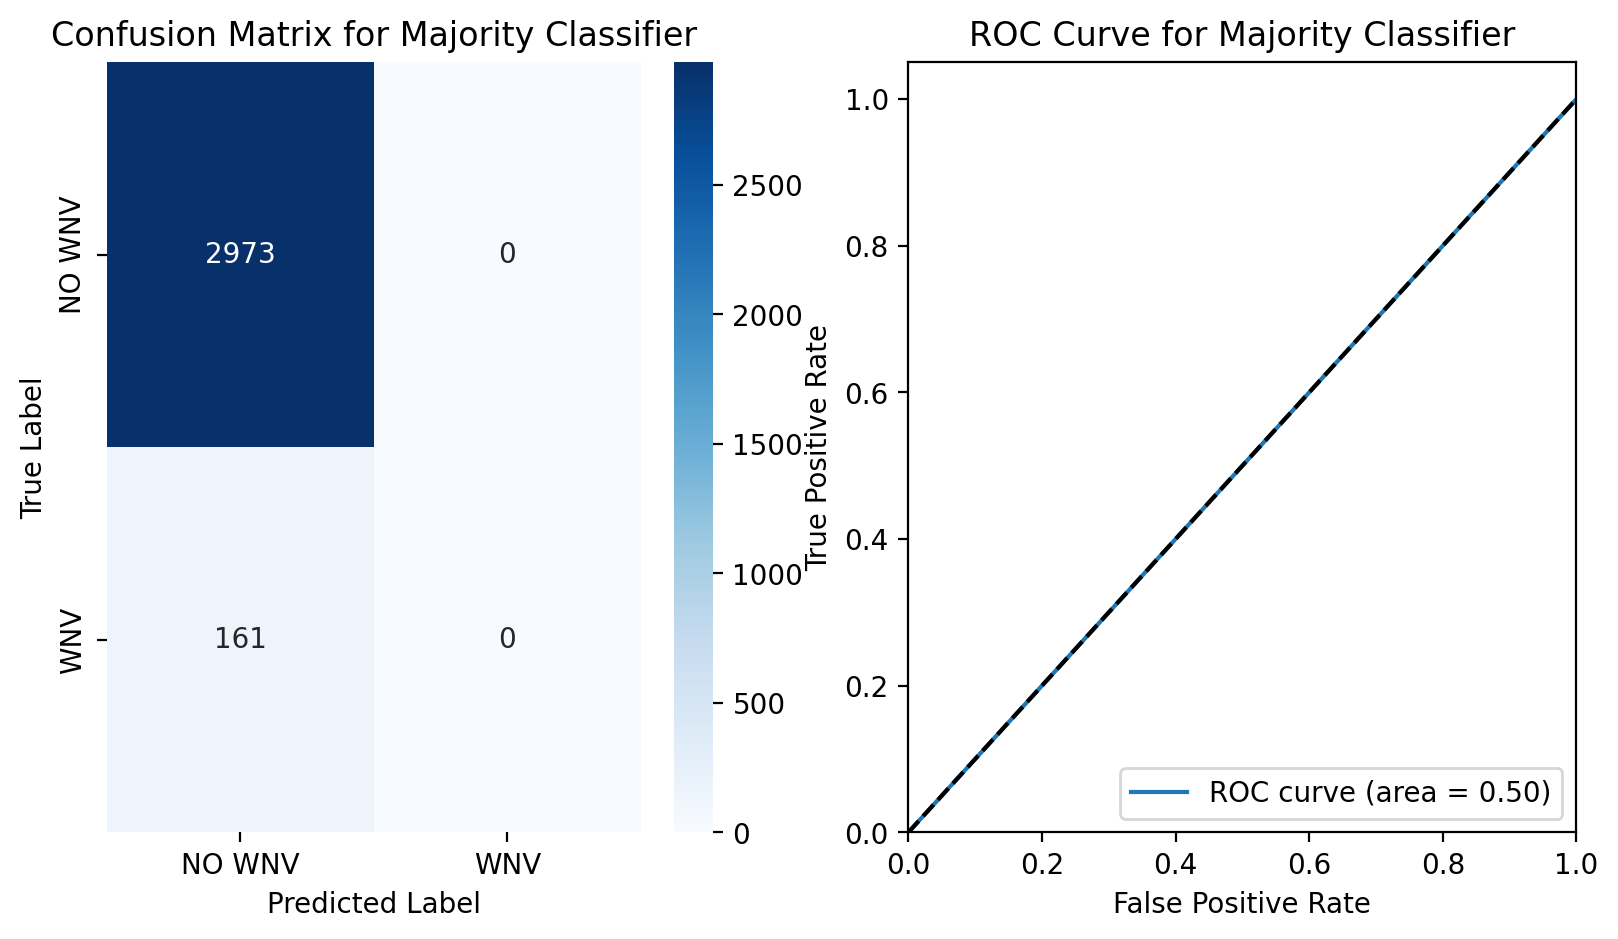

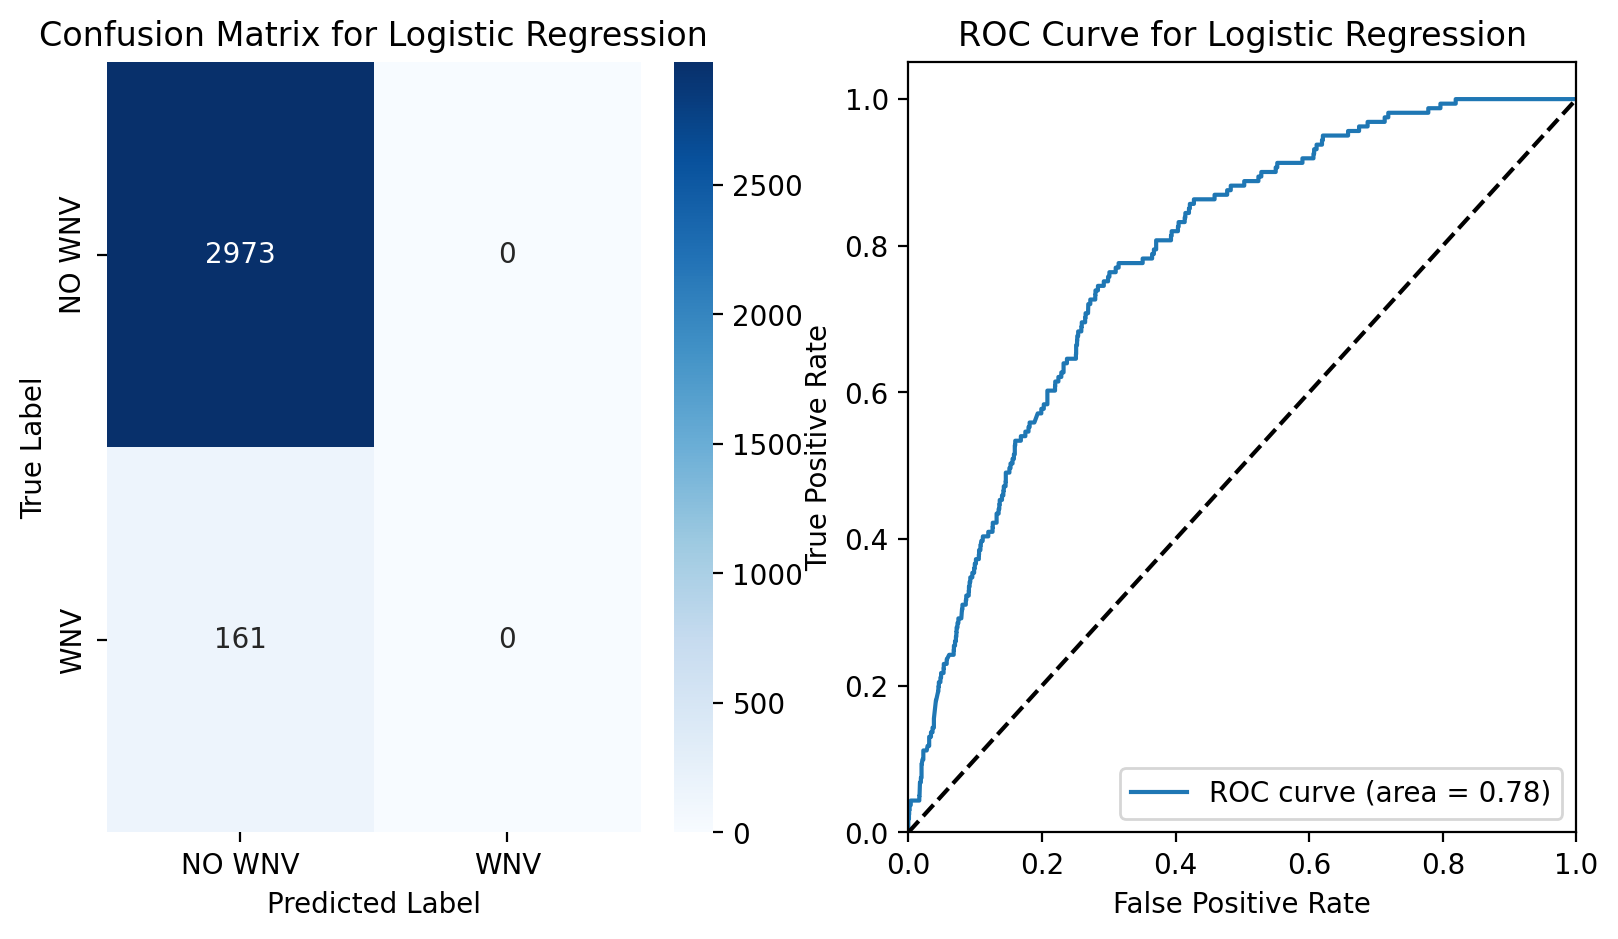

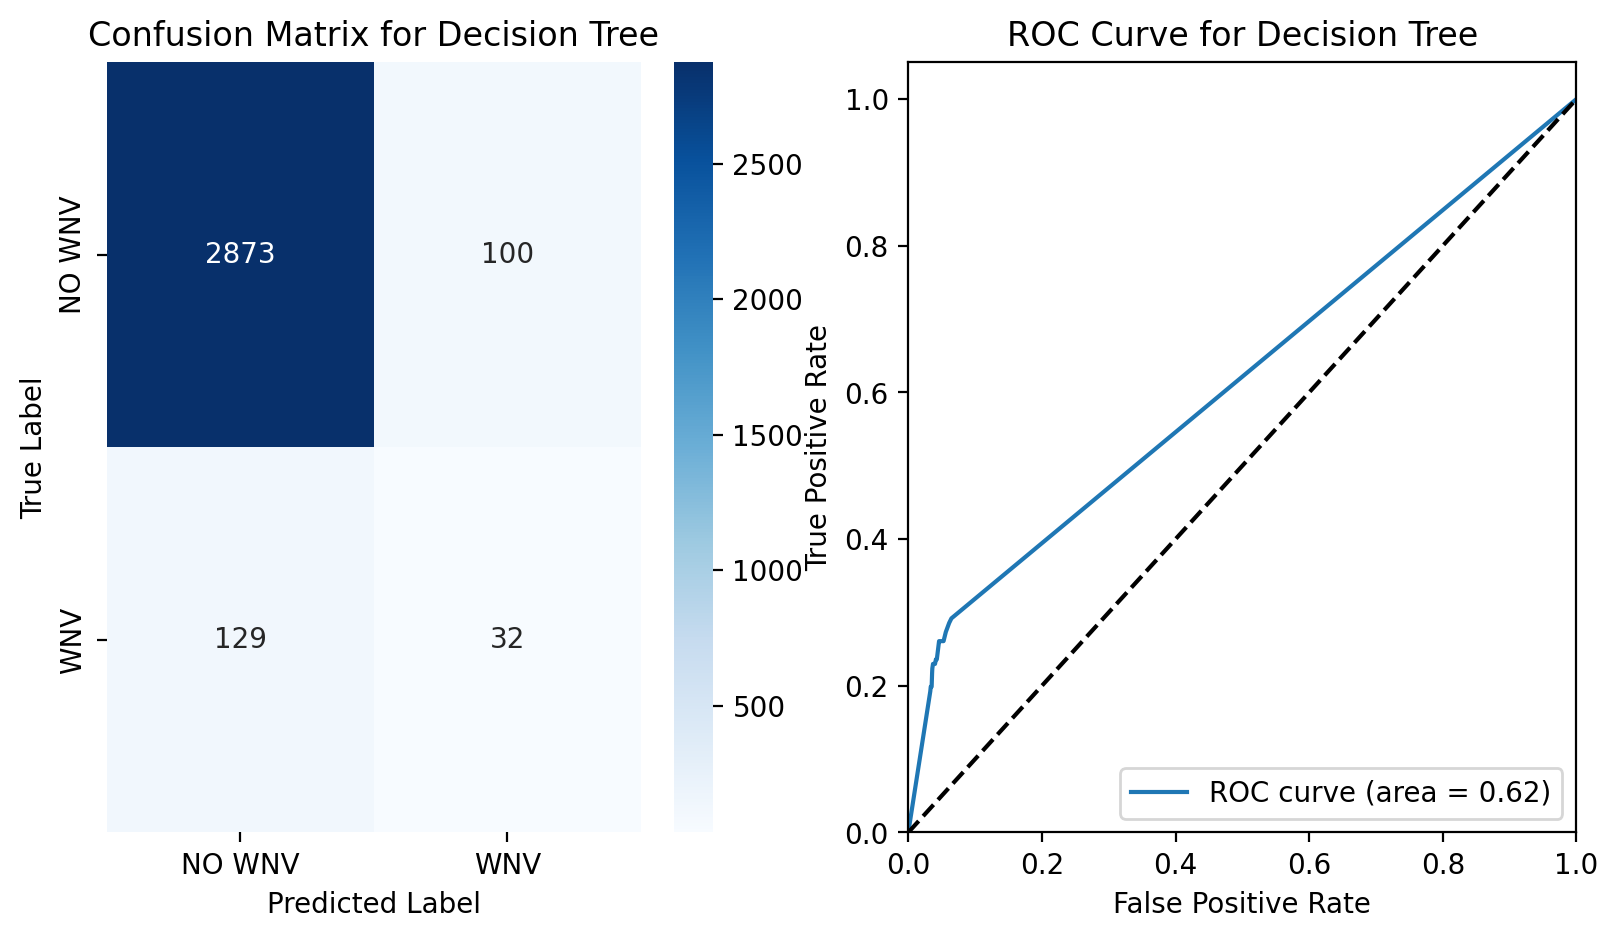

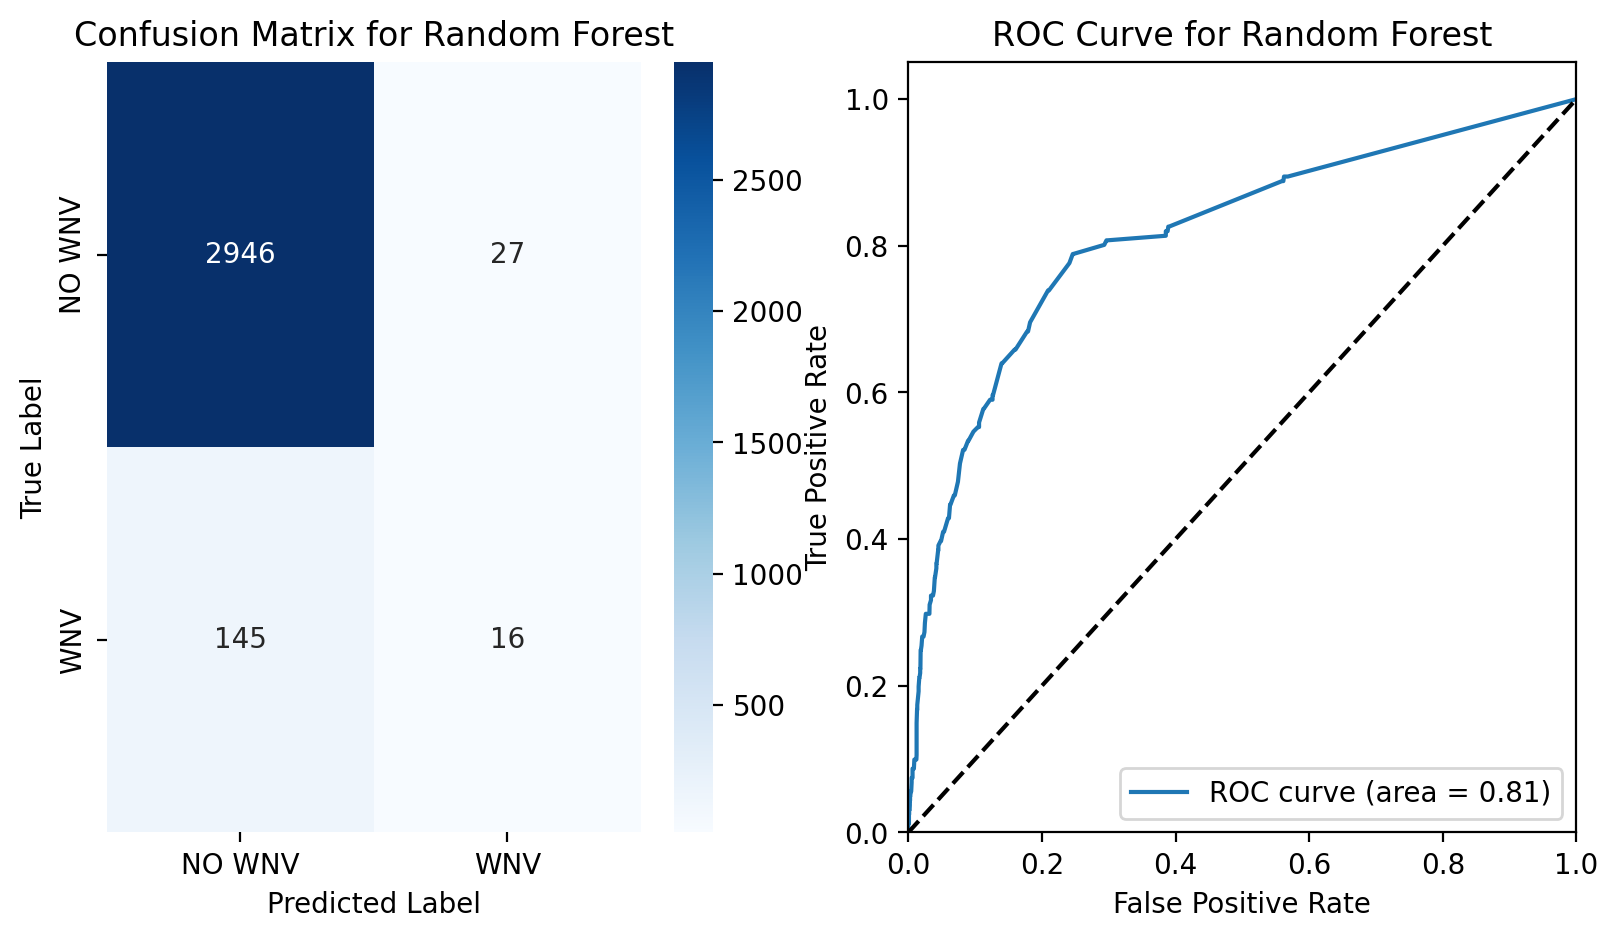

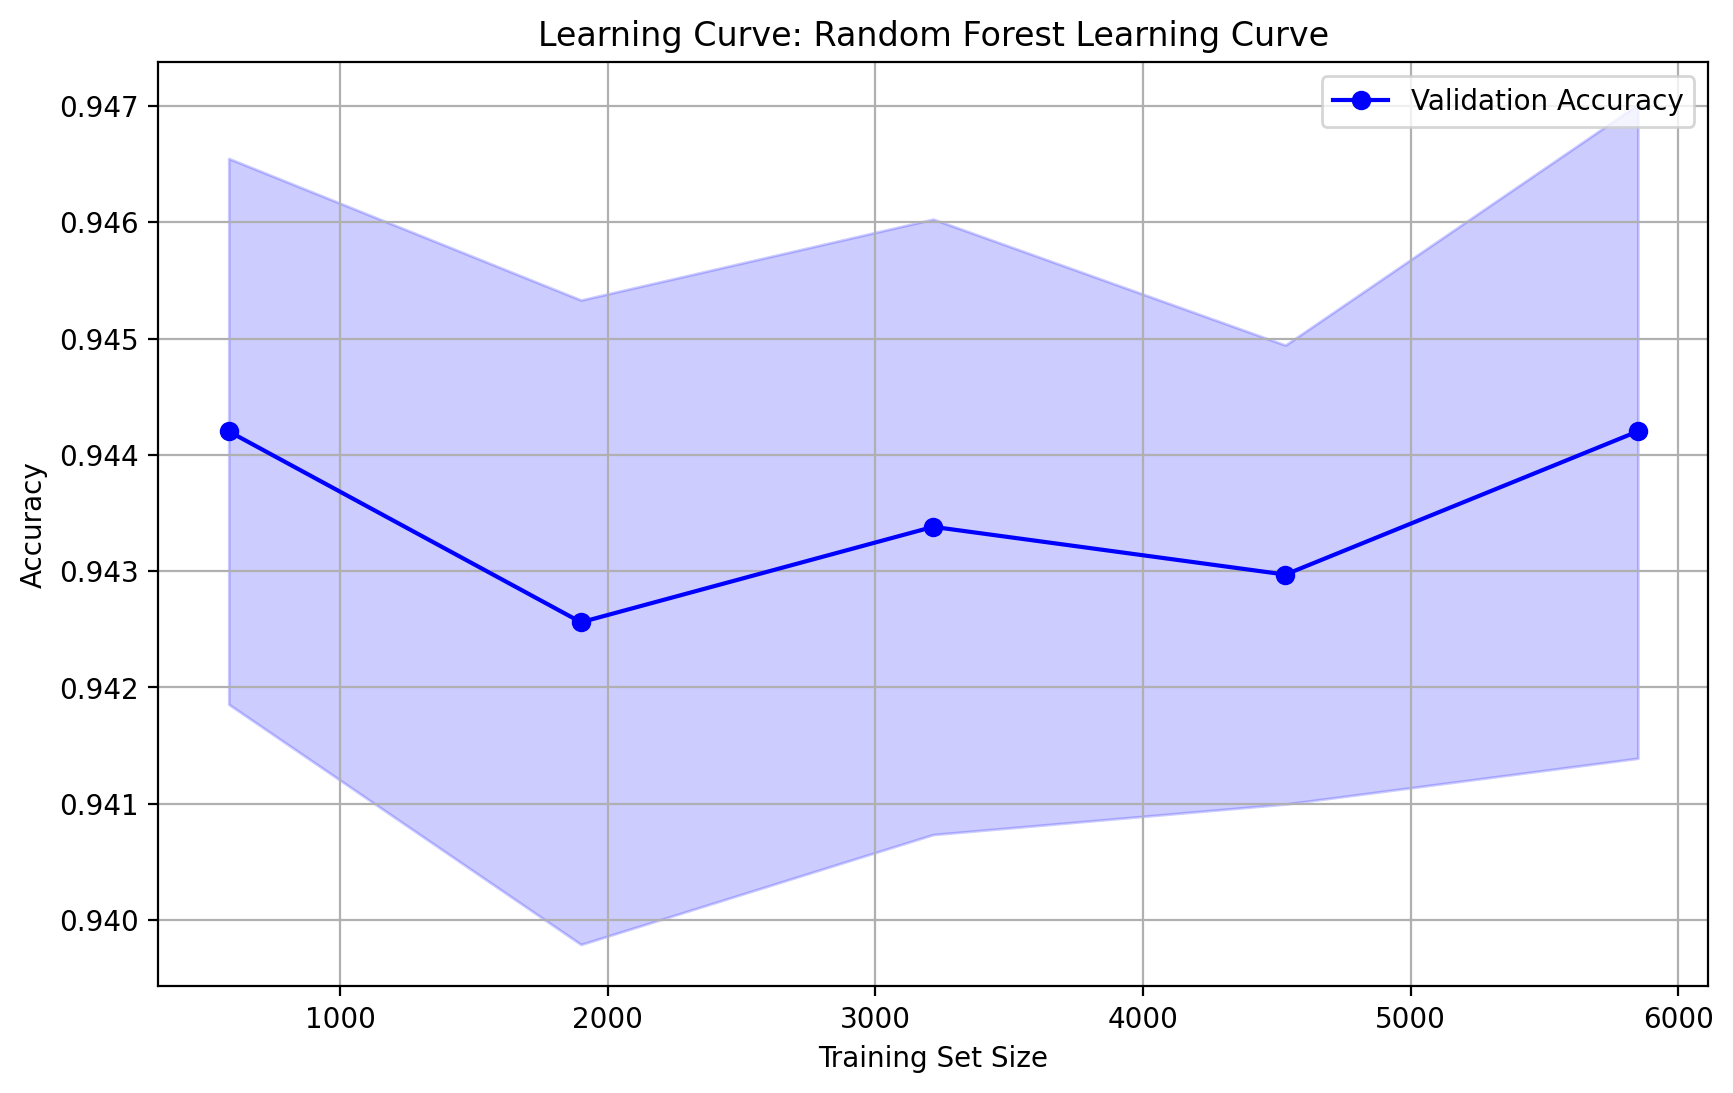

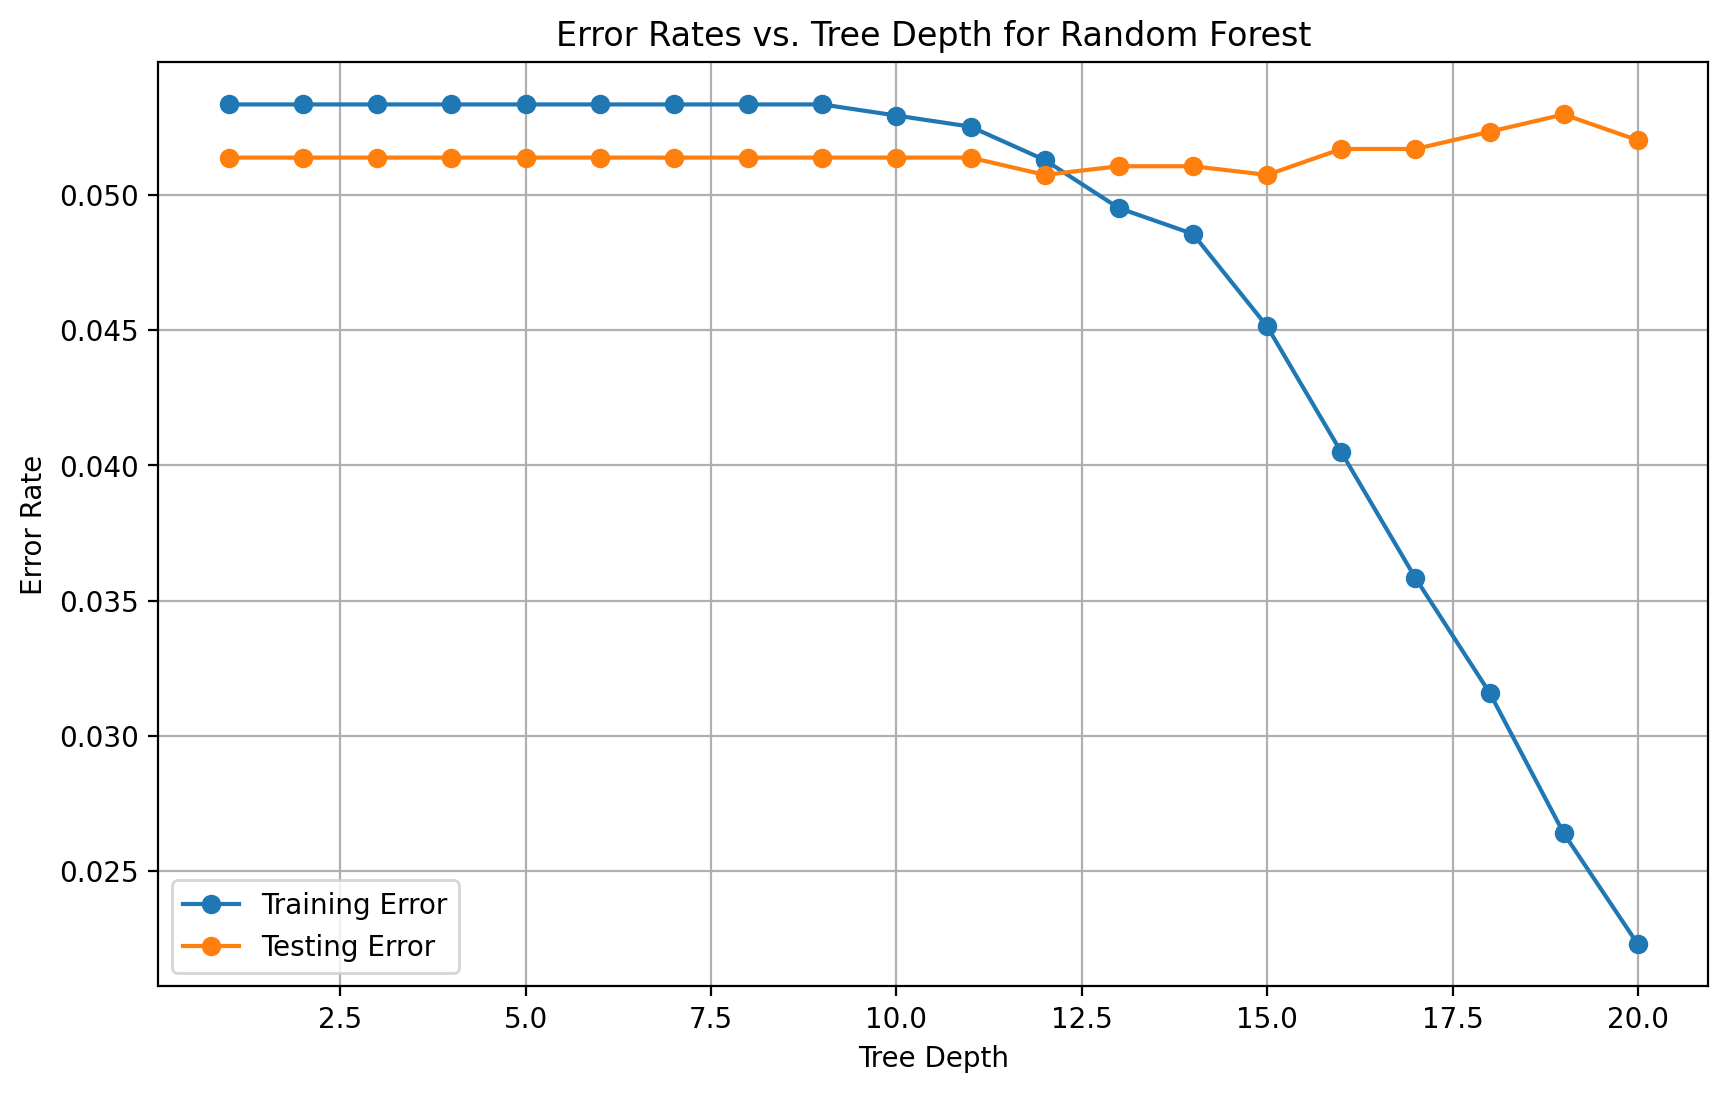

Best parameters for Random Forest: {'n_estimators': 500}
Evaluating hyperparameter-tuned Random Forest model:


,Accuracy,ROC AUC
Random Forest,0.94448,0.82907


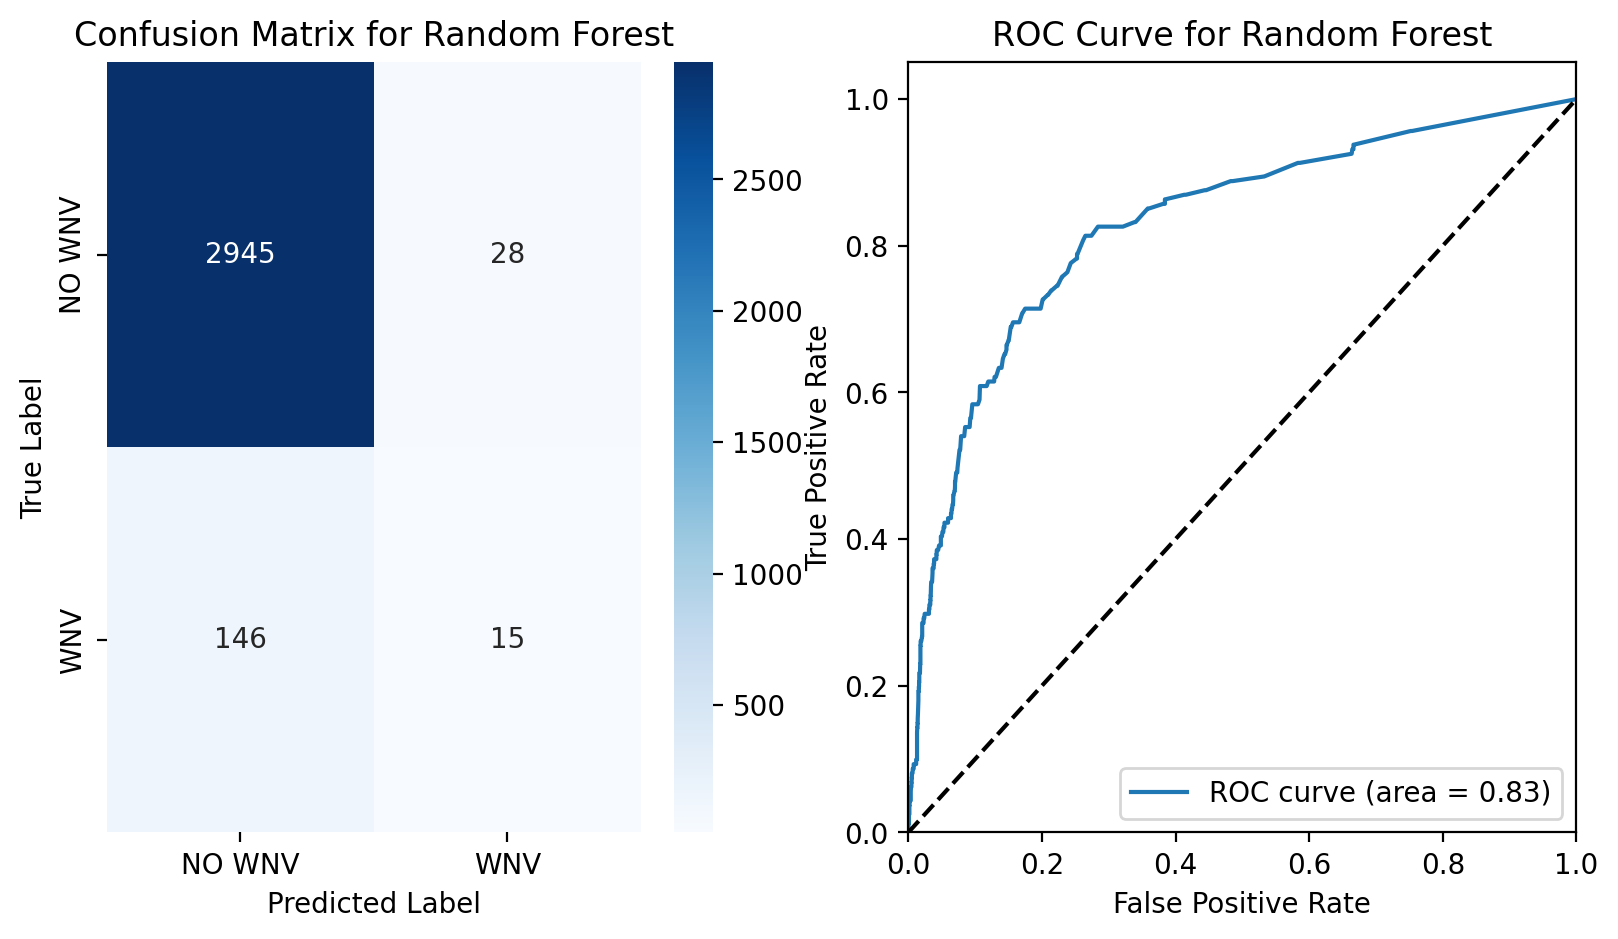

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from IPython.display import display, Markdown

# Settings for plotting
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'  # High resolution figures")

def prepare_data_for_modeling(train):
    X = train.drop(["WnvPresent"], axis=1)
    y = train['WnvPresent']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

def prepare_models():
    models = {
        'Majority Classifier': DummyClassifier(strategy="most_frequent"),
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier()
    }
    return models

def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def evaluate_models(trained_models, X_test, y_test, X_train, y_train):
    results = {}
    class_names = ['NO WNV', 'WNV']
    
    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A',
        }
        
        plt.figure(figsize=(25, 5))
        
        # Plotting confusion matrix
        plt.subplot(1, 5, 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # Plotting ROC curve if probabilities are available
        if y_prob is not None:
            plt.subplot(1, 5, 2)
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name}')
            plt.legend(loc="lower right")

    
    return pd.DataFrame(results).T

def hyperparameter_tuning(X_train, y_train):
    
    param_grid = {
        'n_estimators': [100, 200, 300, 500],  
        # 'max_depth': [None, 10, 12, 15],  
        # 'min_samples_split': [2, 10],  
        # 'min_samples_leaf': [1, 5]  
    }
    
    rf_model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=3, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters for Random Forest: {grid_search.best_params_}")
    
    return best_model

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, test_mean, marker='o', color='b', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='b')
    plt.title(f'Learning Curve: {title}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def plot_fitting_graph(X_train, y_train, X_test, y_test, depths):
    train_errors = []
    test_errors = []

    for depth in depths:
        rf = RandomForestClassifier(max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)

        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)

        train_errors.append(1 - accuracy_score(y_train, train_pred))  # Error rate
        test_errors.append(1 - accuracy_score(y_test, test_pred))  # Error rate

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_errors, label='Training Error', marker='o')
    plt.plot(depths, test_errors, label='Testing Error', marker='o')
    plt.xlabel('Tree Depth')
    plt.ylabel('Error Rate')
    plt.title('Error Rates vs. Tree Depth for Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

def main_workflow():
    display(Markdown("## Training and Evaluation"))

    # Load datasets
    train_cleaned = pd.read_csv('../data/cleaned_train_encoded.csv')
    print(len(train_cleaned))
    X_train, X_test, y_train, y_test = prepare_data_for_modeling(train_cleaned)

    # Prepare and train models
    models = prepare_models()
    trained_models = train_models(models, X_train, y_train)

    # Evaluate initial models and display results
    print("Evaluating initial models:")
    results_df = evaluate_models(trained_models, X_test, y_test, X_train, y_train)
    display(results_df)

    # Plot learning curve for Random Forest
    plot_learning_curve(models['Random Forest'], X_train, y_train, title='Random Forest Learning Curve')
    plot_fitting_graph(X_train, y_train, X_test, y_test, depths=range(1, 21))
    
    # Perform hyperparameter tuning for Random Forest
    best_rf_model = hyperparameter_tuning(X_train, y_train)
    
    # Re-evaluate the best model
    print("Evaluating hyperparameter-tuned Random Forest model:")
    best_trained_models = {'Random Forest': best_rf_model}
    best_results_df = evaluate_models(best_trained_models, X_test, y_test, X_train, y_train)
    display(best_results_df)

main_workflow()
